In [2]:
#importing libraries
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from keras.callbacks import History , ModelCheckpoint
import cv2
from cv2 import imread, createCLAHE 
from keras.optimizers import Adam 
#from glob import globfrom keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
%matplotlib inline
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, UpSampling1D, RepeatVector,TimeDistributed
from keras.layers import Embedding
from keras.models import Model
from keras.layers import Input, GaussianNoise
from keras.models import load_model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.resnet import ResNet101, preprocess_input
from keras.optimizers import SGD, Adam, RMSprop
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.densenet import DenseNet201
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split

**Changing the directory**

In [3]:
print(os.getcwd())

/content


In [4]:
os.chdir('drive')

In [5]:
os.chdir('My Drive')

In [6]:
print(os.getcwd())

/content/drive/My Drive


**Getting the path of images and masks**

In [7]:
image_path = os.path.join("data/Lung Segmentation/CXR_png")
mask_path = os.path.join("data/Lung Segmentation/","masks/")

In [8]:
mask = os.listdir(mask_path)

In [9]:
images = os.listdir(image_path)
mask = os.listdir(mask_path)
mask = [fName.split(".png")[0] for fName in mask]
image_file_name = [fName.split("_mask")[0] for fName in mask]

In [10]:
#getting training files
check = [i for i in mask if "mask" in i]
print("Total mask that has modified name:",len(check))
# 0 represents normal 1 represents abnormal

Total mask that has modified name: 566


In [11]:
#getting images and masks in same list
testing_files = set(os.listdir(image_path)) & set(os.listdir(mask_path))

In [12]:
testing_files = list(testing_files)

In [13]:
training_files = check

In [14]:
#getting labels from testing files
testing_files[0][12:13]
label_test = []
for i in range(len(testing_files)):
  if testing_files[i][12:13] == '1':
    label_test.append('1')
  else:
    label_test.append('0')


In [15]:
#getting labels from training files
training_files[0][12:13]
label_train= []
for i in range(len(training_files)):
  if training_files[i][12:13] == '1':
    label_train.append('1')
  else:
    label_train.append('0')

  

In [16]:
#function that separates xtrain and ytrain and resizing the image into 256 x 256 
def getData(X_shape, flag = "test"):
    im_array = []
    mask_array = []
    
    if flag == "test":
        for i in tqdm(testing_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i)),(X_shape,X_shape))[:,:,0]
           
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i)),(X_shape,X_shape))[:,:,0]
          
            im_array.append(im)
            mask_array.append(mask)
        
        return im_array,mask_array
    
    if flag == "train":
        for i in tqdm(training_files): 
            im = cv2.resize(cv2.imread(os.path.join(image_path,i.split("_mask")[0]+".png")),(X_shape,X_shape))[:,:,0]
            mask = cv2.resize(cv2.imread(os.path.join(mask_path,i+".png")),(X_shape,X_shape))[:,:,0]

            im_array.append(im)
            mask_array.append(mask)

        return im_array,mask_array

In [17]:
#separaing training and testing 
dim = 256
X_train,y_train = getData(dim,flag="train")
X_test, y_test = getData(dim)

100%|██████████| 138/138 [11:55<00:00,  5.18s/it]


In [19]:
#reshaping the dimensions
X_train = np.array(X_train).reshape(len(X_train),dim,dim,1)
y_train = np.array(y_train).reshape(len(y_train),dim,dim,1)
X_test = np.array(X_test).reshape(len(X_test),dim,dim,1)
y_test = np.array(y_test).reshape(len(y_test),dim,dim,1)
assert X_train.shape == y_train.shape
assert X_test.shape == y_test.shape
images = np.concatenate((X_train,X_test),axis=0)
mask  = np.concatenate((y_train,y_test),axis=0)

In [20]:
print("shape of X_train", X_train.shape)
print("shape of y_train", y_train.shape)
print("shape of X_test", X_test.shape)
print("shape of y_test", y_test.shape)


shape of X_train (566, 256, 256, 1)
shape of y_train (566, 256, 256, 1)
shape of X_test (138, 256, 256, 1)
shape of y_test (138, 256, 256, 1)


In [21]:
#appending the label
label = label_train + label_test

In [22]:
y = np.array(label)

**Making Unet architecture**

In [23]:
def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

In [24]:
model = unet(input_size=(256,256,1))
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 32) 0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [ ]:
#plot_model(model, to_file='unet.png', show_shapes=True, show_layer_names=True)

In [25]:


model.compile(optimizer=Adam(lr=2e-4), loss=[dice_coef_loss], metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, (mask>127).astype(np.float32), test_size = 0.1,random_state = 2018)

train_Vol, test_Vol, train_Seg, test_seg = train_test_split(train_vol,train_seg, test_size = 0.1, random_state = 2018)


loss_history = model.fit(x = train_Vol,y = train_Seg,batch_size = 2,epochs = 10, validation_data =(test_Vol,test_seg))


Epoch 1/10
285/285 [==============================] - 14s 47ms/step - loss: -0.7952 - dice_coef: 0.7954 - binary_accuracy: 0.8924 - val_loss: -0.9163 - val_dice_coef: 0.9163 - val_binary_accuracy: 0.9574
Epoch 2/10
285/285 [==============================] - 12s 43ms/step - loss: -0.9310 - dice_coef: 0.9311 - binary_accuracy: 0.9659 - val_loss: -0.9415 - val_dice_coef: 0.9415 - val_binary_accuracy: 0.9703
Epoch 3/10
285/285 [==============================] - 13s 44ms/step - loss: -0.9447 - dice_coef: 0.9447 - binary_accuracy: 0.9728 - val_loss: -0.9466 - val_dice_coef: 0.9466 - val_binary_accuracy: 0.9724
Epoch 4/10
285/285 [==============================] - 13s 45ms/step - loss: -0.9497 - dice_coef: 0.9497 - binary_accuracy: 0.9753 - val_loss: -0.9439 - val_dice_coef: 0.9439 - val_binary_accuracy: 0.9716
Epoch 5/10
285/285 [==============================] - 13s 45ms/step - loss: -0.9547 - dice_coef: 0.9547 - binary_accuracy: 0.9778 - val_loss: -0.9552 - val_dice_coef: 0.9552 - val_bina

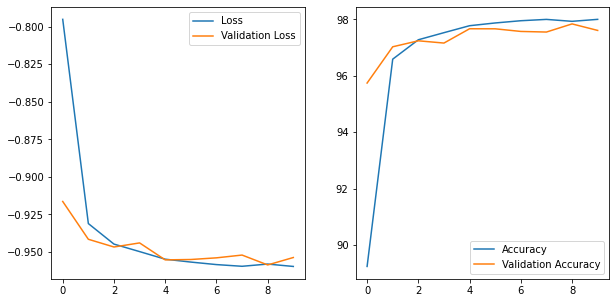

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

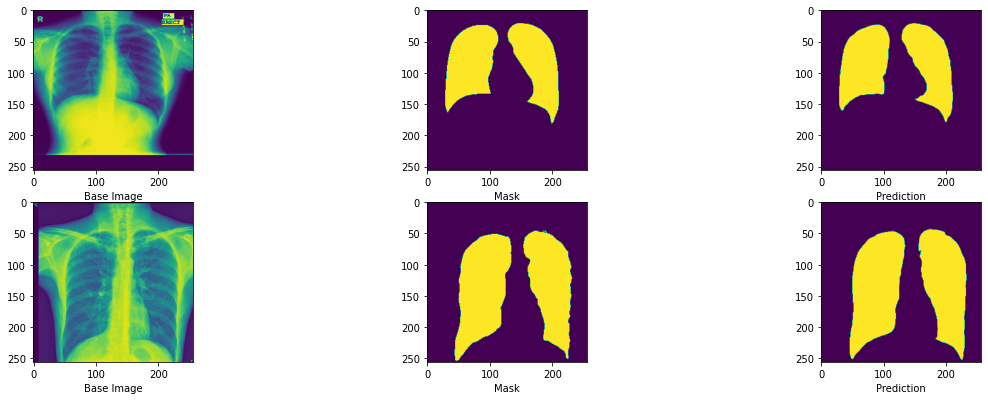

In [27]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol)

plt.figure(figsize=(20,10))

for i in range(0,6,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

**Predicting the train data from Unet and passing to combined model**

In [28]:
#splitting the data again and predicting from the model
train_X, test_X, train_y, test_y = train_test_split((images-127.0)/127.0, y, test_size = 0.2,random_state = 20)

In [29]:
#predicting the train data
pred_train = model.predict(train_X)

In [30]:
#train shape
pred_train.shape

(563, 256, 256, 1)

**Pretrained model only takes 3 channel input so converting into RGB**

In [34]:
#converting grayscale to rgb (train data)
rgb = []
for i in range(len(pred_train)):
  rgb.append(np.repeat(pred_train[i,],3,-1))

In [35]:
#storing in numpy array
rgb_train = np.array(rgb)

In [36]:
rgb_train.shape

(563, 256, 256, 3)

**Predicting the test data**

In [37]:
pred_test = model.predict(test_X)

In [38]:
pred_test.shape

(141, 256, 256, 1)

**Converting the test data to RGB channel**

In [39]:
rgb_ = []
for i in range(len(pred_test)):
  rgb_.append(np.repeat(pred_test[i,],3,-1))

In [40]:
rgb_test = np.array(rgb_)

In [41]:
rgb_test.shape

(141, 256, 256, 3)

**labels to categorical**

In [42]:
Y_train = []
for i in range(len(train_y)):
  Y_train.append(int(train_y[i]))


In [43]:
Y_test = []
for i in range(len(test_y)):
  Y_test.append(int(test_y[i]))

In [44]:
Y_train = np.array(Y_train)
Y_test = np.array(Y_test)

In [45]:
train_Y = tf.keras.utils.to_categorical(Y_train, num_classes=2)

In [46]:
test_Y = tf.keras.utils.to_categorical(Y_test, num_classes=2)

**InceptionV3 and resnet**

In [47]:
model_V3 = tf.keras.applications.InceptionV3(weights='imagenet',input_tensor=Input(shape=(256, 256, 3)), include_top=False)
ResNet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

94773248/94765736 [==============================] - 1s 0us/step


In [49]:

for layer in model_V3.layers:
    layer.trainable = False
for layer in ResNet50.layers:
    layer.trainable = False

In [50]:
visible = Input(shape=(256,256,3))

model1 = model_V3(visible)
model2 = ResNet50(visible)

In [51]:
model1 = GlobalAveragePooling2D()(model1)
model2 = GlobalAveragePooling2D()(model2)
merge = concatenate([model1,model2])
#adding dense layers
hidden1 = Dense(250, activation='relu')(merge)
hidden2 = Dense(250, activation='relu')(hidden1)
hidden3 = Dense(250, activation='relu')(hidden2)
output = Dense(2, activation='softmax')(hidden3)
combined_inception = Model(inputs=visible, outputs=output)

**Compiling and training the model**

In [52]:
from keras.callbacks import History , ModelCheckpoint

history = History()
checkpoint = ModelCheckpoint('Resnet-v3' ,monitor='val_accuracy', save_best_only=True)

In [53]:
combined_inception.compile(optimizer=RMSprop(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy'] )

In [54]:
history = combined_inception.fit(rgb_train,train_Y,epochs =70,batch_size=2,validation_data = (rgb_test,test_Y), verbose=1,callbacks = [history , checkpoint])

Epoch 1/70
282/282 [==============================] - ETA: 0s - loss: 0.7164 - accuracy: 0.5861WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Resnet-v3/assets
282/282 [==============================] - 79s 279ms/step - loss: 0.7164 - accuracy: 0.5861 - val_loss: 0.7082 - val_accuracy: 0.5248
Epoch 2/70
282/282 [==============================] - 11s 38ms/step - loss: 0.6351 - accuracy: 0.6661 - val_loss: 1.0751 - val_accuracy: 0.4539
Epoch 3/70
282/282 [==============================] - 76s 268ms/step - loss: 0.6062 - accuracy: 0.7034 

In [57]:
model_history1 = np.array(history.history)
#np.save('Transfer-learning/model_history1', model_history)

In [58]:
np.save('Transfer-learning/model_history1', model_history1)

In [59]:
model_history1 = np.load('Transfer-learning/model_history1.npy', allow_pickle=True)
val_acc1 = model_history1.item().get('val_accuracy')
acc1 = model_history1.item().get('accuracy')

In [122]:
#plt.plot(val_acc1)

In [61]:
combined_inception.save('Transfer-learning/model1')

INFO:tensorflow:Assets written to: Transfer-learning/model1/assets


In [62]:
combined_model_V3 = load_model('Resnet-v3')

In [63]:
combined_model_V3.evaluate(rgb_test,test_Y)

5/5 [==============================] - 1s 296ms/step - loss: 0.6384 - accuracy: 0.7730


[0.6384482383728027, 0.7730496525764465]

**VGG16 and Resnet 50 model**

In [64]:
#getting 2 models
vgg_imagenet = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
#ResNet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

58892288/58889256 [==============================] - 0s 0us/step


In [65]:

for layer in vgg_imagenet.layers:
    layer.trainable = False
for layer in ResNet50.layers:
    layer.trainable = False

In [66]:
#vgg_imagenet.summary()

In [67]:
#ResNet50.summary()

In [68]:
visible = Input(shape=(256,256,3))

model11 = vgg_imagenet(visible)
model21 = ResNet50(visible)

In [69]:
model11 = GlobalAveragePooling2D()(model11)
model21 = GlobalAveragePooling2D()(model21)

In [70]:
#combining 2 models
merge = concatenate([model11,model21])

In [71]:
#adding dense layers
hidden1 = Dense(250, activation='relu')(merge)    
hidden2 = Dense(250, activation='relu')(hidden1)
hidden3 = Dense(250, activation='relu')(hidden2)
output = Dense(2, activation='softmax')(hidden3)
combined_model_vgg = Model(inputs=visible, outputs=output)

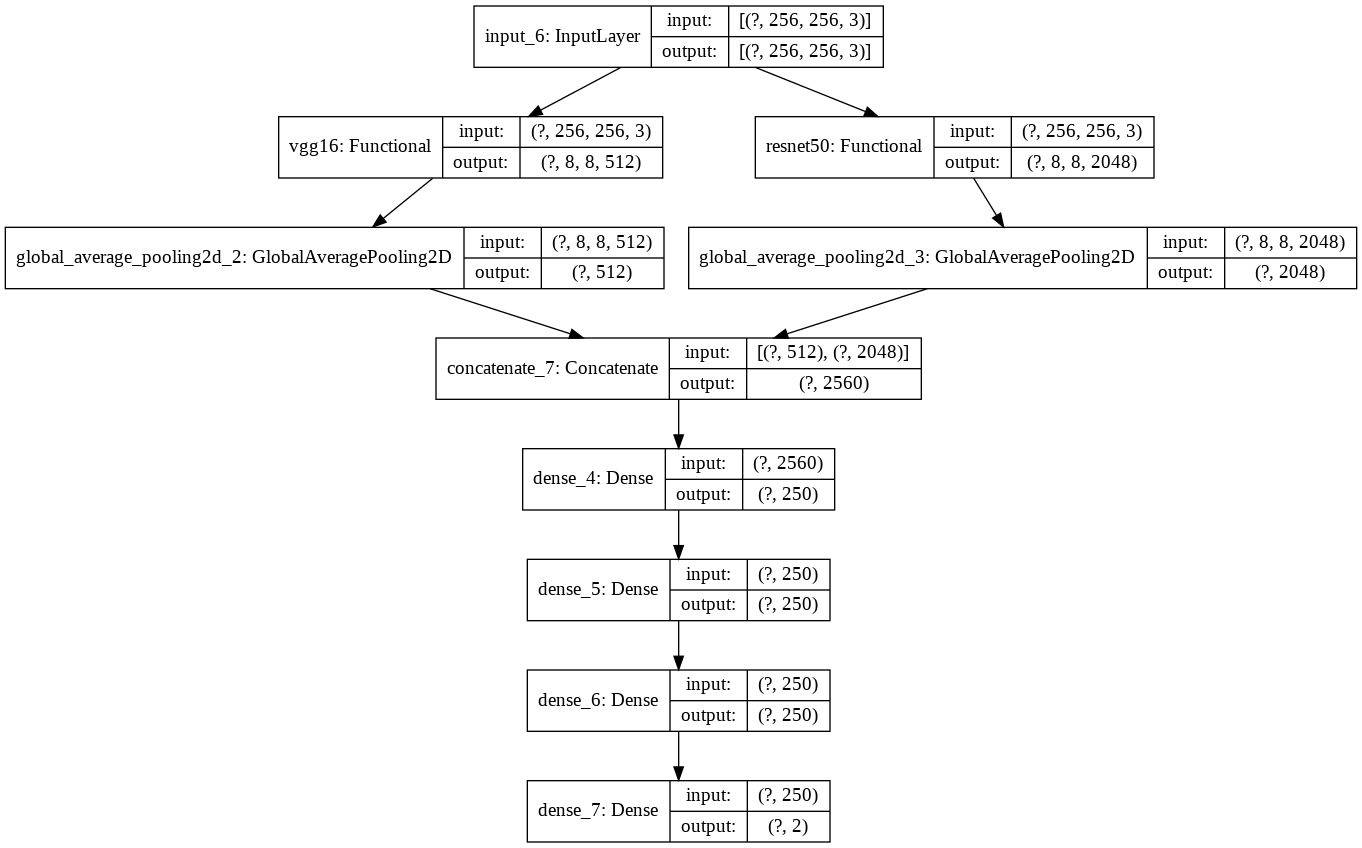

In [72]:
plot_model(combined_model_vgg, to_file='combined_model_VGG.png', show_shapes=True, show_layer_names=True)

**Compiling and training the model**

In [73]:
combined_model_vgg.compile(optimizer=RMSprop(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy'] )

In [74]:


history_resv = History()
checkpoint = ModelCheckpoint('VGG16-Resnet50' ,monitor = 'val_accuracy', save_best_only=True)

In [75]:
history_resv = combined_model_vgg.fit(rgb_train,train_Y,epochs =70,batch_size=2,validation_data = (rgb_test,test_Y), verbose=1, callbacks=[history_resv,checkpoint])

Epoch 1/70
282/282 [==============================] - 40s 141ms/step - loss: 0.7244 - accuracy: 0.5346 - val_loss: 0.6526 - val_accuracy: 0.6383
Epoch 2/70
282/282 [==============================] - 11s 37ms/step - loss: 0.6697 - accuracy: 0.5808 - val_loss: 0.6746 - val_accuracy: 0.5816
Epoch 3/70
282/282 [==============================] - 11s 38ms/step - loss: 0.6422 - accuracy: 0.6412 - val_loss: 0.6809 - val_accuracy: 0.5957
Epoch 4/70
282/282 [==============================] - 39s 138ms/step - loss: 0.6231 - accuracy: 0.6679 - val_loss: 0.5607 - val_accuracy: 0.7021
Epoch 5/70
282/282 [==============================] - 11s 37ms/step - loss: 0.6088 - accuracy: 0.6572 - val_loss: 0.5746 - val_accuracy: 0.6879
Epoch 6/70
282/282 [==============================] - 11s 38ms/step - loss: 0.5946 - accuracy: 0.6767 - val_loss: 1.0561 - val_accuracy: 0.5887
Epoch 7/70
282/282 [==============================] - 38s 136ms/step - loss: 0.5901 - accuracy: 0.6927 - val_loss: 0.5407 - val_accura

In [76]:
model_history2 = np.array(history_resv.history)

In [77]:
np.save('Transfer-learning/model_history2', model_history2)

In [78]:
model_history2 = np.load('Transfer-learning/model_history2.npy', allow_pickle=True)
val_acc2 = model_history2.item().get('val_accuracy')
acc2 = model_history2.item().get('accuracy')

In [79]:
#saving the model 
combined_model_vgg.save('Transfer-learning/model2')

INFO:tensorflow:Assets written to: Transfer-learning/model2/assets


In [ ]:
#loading the best model
Vggresnet= load_model('VGG16-Resnet50')

In [ ]:
#evaluate best model
Vggresnet.evaluate(rgb_test,test_Y)

5/5 [==============================] - 2s 305ms/step - loss: 0.5056 - accuracy: 0.7943


[0.5055732727050781, 0.7943262457847595]

**Resnet combined model**

In [89]:
ResNett = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))
ResNet101 = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(256, 256, 3)))

In [88]:
for layer in ResNet50.layers:
    layer.trainable = False

for layer in ResNet101.layers:
    layer.trainable = False

In [90]:
visible = Input(shape=(256,256,3))

model_r1 = ResNet50(visible)
model_r2 = ResNet101(visible)

In [91]:
model_r1 = GlobalAveragePooling2D()(model_r1)
model_r2 = GlobalAveragePooling2D()(model_r2)

In [92]:
merge3 = concatenate([model_r1,model_r2])

In [93]:
hidden1 = Dense(500, activation='relu')(merge3)
hidden2 = Dense(500, activation='relu')(hidden1)
hidden3 = Dense(500, activation='relu')(hidden2)
output = Dense(2, activation='softmax')(hidden3)
combined_model_resnet = Model(inputs=visible, outputs=output)

In [94]:
history_res50 = History()
checkpoint = ModelCheckpoint('Resnet50-101',monitor='val_accuracy', save_best_only=True)

**Compiling and training the model**

In [95]:
combined_model_resnet.compile(optimizer=RMSprop(lr=0.0002), loss='binary_crossentropy', metrics=['accuracy'])

In [96]:
combined_model_resnet.fit(rgb_train,train_Y,epochs =70,batch_size=2,validation_data = (rgb_test,test_Y), verbose=1,callbacks=[checkpoint,history_res50])

Epoch 1/70
282/282 [==============================] - 102s 362ms/step - loss: 0.7348 - accuracy: 0.5577 - val_loss: 0.7464 - val_accuracy: 0.5745
Epoch 2/70
282/282 [==============================] - 97s 343ms/step - loss: 0.6559 - accuracy: 0.6128 - val_loss: 0.8317 - val_accuracy: 0.5887
Epoch 3/70
282/282 [==============================] - 89s 317ms/step - loss: 0.6384 - accuracy: 0.6519 - val_loss: 0.5984 - val_accuracy: 0.6738
Epoch 4/70
282/282 [==============================] - 13s 46ms/step - loss: 0.6163 - accuracy: 0.6536 - val_loss: 0.6708 - val_accuracy: 0.6028
Epoch 5/70
282/282 [==============================] - 13s 47ms/step - loss: 0.6078 - accuracy: 0.6803 - val_loss: 0.5856 - val_accuracy: 0.6738
Epoch 6/70
282/282 [==============================] - 13s 46ms/step - loss: 0.5924 - accuracy: 0.7016 - val_loss: 0.6745 - val_accuracy: 0.6738
Epoch 7/70
282/282 [==============================] - 13s 46ms/step - loss: 0.5842 - accuracy: 0.7105 - val_loss: 0.6675 - val_accur

In [97]:
model_history3 = np.array(history_res50.history)


In [98]:
np.save('Transfer-learning/model_history3', model_history3)

In [99]:
model_history3 = np.load('Transfer-learning/model_history3.npy', allow_pickle=True)
val_acc3 = model_history2.item().get('val_accuracy')
acc3 = model_history2.item().get('accuracy')

In [100]:
#saving the model 
combined_model_resnet.save('Transfer-learning/model3')

INFO:tensorflow:Assets written to: Transfer-learning/model3/assets


**Evaluating all models**

In [107]:
print("Feature combination: Resnet50 and Inception V3")
Resnetv3 = load_model('Resnet-v3')
Resnetv3.evaluate(rgb_test,test_Y)

Feature combination: Resnet50 and Inception V3
5/5 [==============================] - 1s 141ms/step - loss: 0.6384 - accuracy: 0.7730


[0.6384482383728027, 0.7730496525764465]

In [108]:
print("feature combination of vgg16 and resnet 50")
history_resv = History()
Resnetvgg16 = load_model('VGG16-Resnet50')
Resnetvgg16.evaluate(rgb_test,test_Y)

feature combination of vgg16 and resnet 50
5/5 [==============================] - 2s 314ms/step - loss: 0.4808 - accuracy: 0.8085


[0.4807780385017395, 0.8085106611251831]

In [109]:
print("feature combination of resnet101 and resnet 50")
history_res50 = History()
Res50101 = load_model('Resnet50-101')
Res50101.evaluate(rgb_test,test_Y)

feature combination of resnet101 and resnet 50
5/5 [==============================] - 1s 214ms/step - loss: 0.5427 - accuracy: 0.7730


[0.5426691770553589, 0.7730496525764465]

**Plotting the best model accuracy**

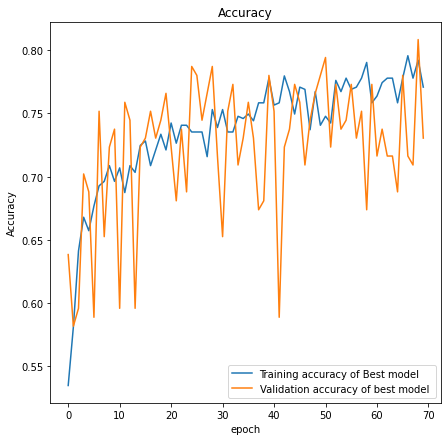

In [112]:
plt.figure(figsize=(7,7))
plt.plot(acc2)
plt.plot(val_acc2)
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy of Best model', 'Validation accuracy of best model '  ], loc='lower right')
plt.show()

**CNN combined model**

In [116]:
cnn_input = Input(shape=(256,256,1))
# first model
model1 = Conv2D(150, kernel_size=3, activation='relu')(cnn_input)
model1= MaxPooling2D(pool_size=(2, 2))(model1)
model1 = Conv2D(100, kernel_size=2, activation='relu')(model1)
model1= MaxPooling2D(pool_size=(2, 2))(model1)
model1 = Conv2D(70, kernel_size=3, activation='relu')(model1)
model1= MaxPooling2D(pool_size=(2, 2))(model1)
model1 = Conv2D(40, kernel_size=3, activation='relu')(model1)
model1= MaxPooling2D(pool_size=(2, 2))(model1)
model1 = Conv2D(30, kernel_size=3, activation='relu')(model1)
model1= MaxPooling2D(pool_size=(2, 2))(model1)
flat1 = Flatten()(model1)

In [117]:
# second model
model2 = Conv2D(100, kernel_size=4, activation='relu')(cnn_input)
model2 = MaxPooling2D(pool_size=(2, 2))(model2)
model2 = Conv2D(70, kernel_size=4, activation='relu')(model2)
model2 = MaxPooling2D(pool_size=(2, 2))(model2)
model2 = Conv2D(40, kernel_size=4, activation='relu')(model2)
model2 = MaxPooling2D(pool_size=(2, 2))(model2)
model2 = Conv2D(30, kernel_size=4, activation='relu')(model2)
model2 = MaxPooling2D(pool_size=(2, 2))(model2)
model2 = Conv2D(30, kernel_size=4, activation='relu')(model2)
model2 = MaxPooling2D(pool_size=(2, 2))(model2)
flat2 = Flatten()(model2)

In [118]:
# merge feature extractors
merge = concatenate([flat1, flat2])
# interpretation layer
hidden1 = Dense(500, activation='relu')(merge)
hidden1 = Dense(250, activation='relu')(hidden1)
hidden1 = Dense(250, activation='relu')(hidden1)
hidden1 = Dense(100, activation='relu')(hidden1)
# prediction output
output = Dense(2, activation='softmax')(hidden1)
model_3 = Model(inputs=cnn_input, outputs=output)
# summarize layers


In [119]:
model_3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [120]:
history_3 = model_3.fit(pred_train,train_Y,epochs=50,batch_size =2, validation_data = (pred_test, test_Y), verbose=1)

Epoch 1/50
282/282 [==============================] - 9s 33ms/step - loss: 0.6966 - accuracy: 0.4902 - val_loss: 0.6912 - val_accuracy: 0.5461
Epoch 2/50
282/282 [==============================] - 9s 31ms/step - loss: 0.6942 - accuracy: 0.5009 - val_loss: 0.6929 - val_accuracy: 0.5461
Epoch 3/50
282/282 [==============================] - 9s 31ms/step - loss: 0.6937 - accuracy: 0.4707 - val_loss: 0.6932 - val_accuracy: 0.4539
Epoch 4/50
282/282 [==============================] - 9s 31ms/step - loss: 0.6934 - accuracy: 0.4476 - val_loss: 0.6928 - val_accuracy: 0.5461
Epoch 5/50
282/282 [==============================] - 9s 31ms/step - loss: 0.6935 - accuracy: 0.5009 - val_loss: 0.6929 - val_accuracy: 0.5461
Epoch 6/50
282/282 [==============================] - 9s 32ms/step - loss: 0.6934 - accuracy: 0.4938 - val_loss: 0.6928 - val_accuracy: 0.5461
Epoch 7/50
282/282 [==============================] - 9s 31ms/step - loss: 0.6934 - accuracy: 0.4796 - val_loss: 0.6927 - val_accuracy: 0.5461

In [121]:
model_3.evaluate(pred_test,test_Y)

5/5 [==============================] - 1s 166ms/step - loss: 0.6929 - accuracy: 0.5461


[0.6929291486740112, 0.5460993051528931]